<a href="https://colab.research.google.com/github/Nacho2904/CURSO-LEARNING1/blob/tareas/clasificador_de_novelas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de novelas

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from google.colab import drive 
import sqlite3
from tqdm import tqdm
import tensorflow as tf

drive.mount('/content/gdrive')
path_a_db = 'gdrive/MyDrive/novelassql.db'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
con = sqlite3.connect(path_a_db)
cur = con.cursor()

In [42]:
cur.execute('SELECT title FROM novelas LIMIT 5')
cur.fetchall()


[('80 Years Of Signing-In At The Cold Palace, I Am Unrivalled',),
 ('999 Times Training System',),
 ('A Certain Hogwarts Magician Professor',),
 ('A Certain Marvel Super Player',),
 ('A Hundredfold Training System Instantly Upgrades 999',)]

In [43]:
df_novelas = pd.read_sql_query("SELECT * from novelas", con)
df_generos = pd.read_sql_query("SELECT * FROM novelas_y_categorias", con)

In [44]:
df_novelas.loc["id"] = pd.to_numeric(df_novelas["id"], errors = "coerce")
df_novelas = df_novelas[df_novelas["id"].notnull()]
df_novelas["id"] = np.int64(df_novelas["id"] + 1)

df_generos.loc["id_novela"] = pd.to_numeric(df_generos["id_novela"], errors = "coerce")
df_generos = df_generos[df_generos["id_novela"].notnull()]
df_generos["id_novela"] = np.int64(df_generos["id_novela"] + 1)
df_generos.columns = ["id", "genero"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [45]:
def normalize_text(corpus,stop_words=None):

  # Convierto a lowercase
  corpus_lower = corpus.str.lower()

  # Elimino signos de puntuación, caracteres raros, etc.
  normalized_corpus = corpus_lower.str.replace(r"[^\w\d\s]+","",regex=True)

  # Elimino espacios innecesarios
  normalized_corpus = normalized_corpus.str.replace(r"\s+"," ",regex=True)

  return normalized_corpus

In [46]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

100%|██████████| 519/519 [00:55<00:00,  9.29it/s]


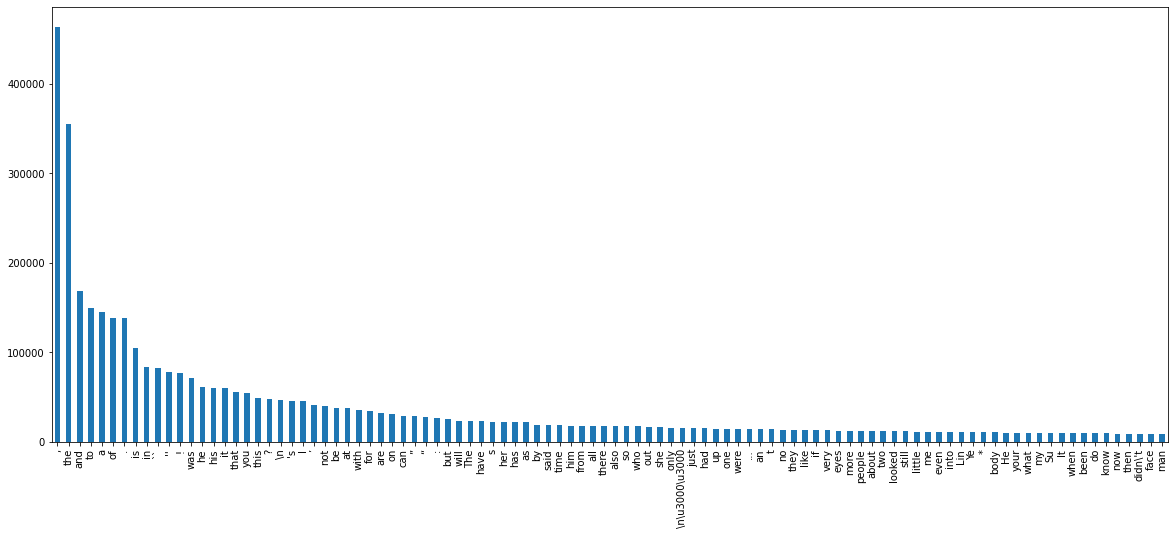

In [47]:
from nltk import word_tokenize
from collections import defaultdict
df_novelas_modificado = df_novelas.copy()

def create_vocabulary(corpus,tokenizer,max_tokens=40000,min_freq=1):
  counts = defaultdict(lambda: 0)
  for comment in tqdm(corpus):
    for token in tokenizer(comment):
      counts[token] += 1

  valid_tokens = sorted([tk for tk in counts.keys() if counts[tk] >= min_freq],key=counts.get,reverse=True)[:max_tokens]
  counts = [counts[tk] for tk in valid_tokens]
  return pd.Series(counts,index=valid_tokens)

df_novelas_modificado["summary"] = normalize_text(df_novelas["summary"],stop_words=stopwords.words('english'))
df_novelas_modificado["first_ten_chapters_text"] = normalize_text(df_novelas["first_ten_chapters_text"],stop_words=stopwords.words('english'))

vocab = create_vocabulary(df_novelas["first_ten_chapters_text"],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab[:100].plot(kind="bar",ax=ax,fontsize=10);

In [48]:
df_novelas_modificado.head()

,id,title,author,genres,summary,first_ten_chapters_text
0,0,Game of Thrones: Wrath of the Sleeping Dragon,Purple Taro Ice Cream,"'Action', 'Fan-Fiction'",song of ice and fire doujincrossing became th...,u3000u3000 rumblingnu3000u3000 the deafening s...
1,1,A Hundredfold Training System Instantly Upgrad...,Coming for Koi,"'Action', 'Adventure', 'Fantasy', 'Xuanhuan'",take a step experience 10100 times basic stan...,ding congratulations on your successful bindin...
2,2,Scoring the Sacred Body of the Ancients from t...,God J,"'Action', 'Adventure', 'Fantasy', 'Xuanhuan'",jun xiaoyao was transported to a mystical wor...,u3000u3000 huangzhou one of the three thousand...
3,3,Godly Choice System,Ye Huo Fen Xin,'Urban Life',ordinary high school students get a godlevel ...,zhonghai city longyang countynas the top three...
4,4,Rebirth of the Best Businesswoman at School,The cold is approaching,"'Romance', 'Urban Life'",in my previous life i was humiliated every da...,the warm spring sun fell sporadically on the w...


In [49]:
obtener_cantidad_de_generos = lambda genres: len(genres.split(','))

df_novelas_modificado = df_novelas_modificado[["genres", "first_ten_chapters_text"]]
df_novelas_modificado["cantGeneros"] = df_novelas_modificado["genres"].map(obtener_cantidad_de_generos)
df_novelas_un_genero = df_novelas_modificado[df_novelas_modificado["cantGeneros"] == 1][["genres", "first_ten_chapters_text"]]
df_novelas_un_genero = df_novelas_un_genero[df_novelas_un_genero["genres"] != '']
df_novelas_un_genero["genres"] = df_novelas_un_genero["genres"].map(str.lower)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [50]:
genres = list(df_novelas_un_genero["genres"].unique())
genres

["'urban life'",
 "'sci-fi'",
 "'romance'",
 "'fan-fiction'",
 "'game'",
 "'fantasy'",
 "'military'",
 "'chinese'",
 "'action'",
 "'sports'",
 "'japanese'",
 "'urban'"]

In [51]:
def vectorize(corpus,tokenizer,vocab):
  N = len(vocab)
  corpus_size = len(corpus)
  X = np.zeros((len(corpus),N))

  token2idx = {tk: i for i, tk in enumerate(vocab.index)}
  for i, article in enumerate(tqdm(corpus)):
    for w in tokenizer(article):
      if w in vocab.index:
        idx = token2idx[w]
        X[i,idx] += 1
  
  return X

X = vectorize(df_novelas_un_genero["first_ten_chapters_text"],word_tokenize,vocab)
y = df_novelas_un_genero["genres"].map({genre:genres.index(genre) for genre in genres})


100%|██████████| 181/181 [00:09<00:00, 19.53it/s]


In [52]:
np.shape(X)

(181, 10000)

In [62]:
input = tf.keras.layers.Input(shape=(10000,))

x_1 = tf.keras.layers.Dense(7500, input_dim = 10000, activation = "ReLU")(input)
x_2 = tf.keras.layers.Dense(3000, input_dim = 10000, activation = "ReLU")(input)
x_3 = tf.keras.layers.Dense(1000, input_dim = 10000, activation = "ReLU")(input)
x_4 = tf.keras.layers.Dense(500, input_dim = 10000, activation = "ReLU")(input)
x_5 = tf.keras.layers.Dense(100, input_dim = 10000, activation = "ReLU")(input)
output = tf.keras.layers.Dense(len(genres), input_dim = 10000, activation = "softmax")(input)

model = tf.keras.models.Model(inputs = input, outputs = output)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=["accuracy"])
hist = model.fit(x=X, y=y, batch_size = 16, epochs=10000,callbacks=[early_stop]);

Epoch 1/10000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Streaming output truncated to the last 5000 lines.
12/12 [==============================] - 0s 6ms/step - loss: 5.7080e-04 - accuracy: 1.0000
Epoch 7502/10000
12/12 [==============================] - 0s 7ms/step - loss: 5.7045e-04 - accuracy: 1.0000
Epoch 7503/10000
12/12 [==============================] - 0s 7ms/step - loss: 5.7018e-04 - accuracy: 1.0000
Epoch 7504/10000
12/12 [==============================] - 0s 7ms/step - loss: 5.6989e-04 - accuracy: 1.0000
Epoch 7505/10000
12/12 [==============================] - 0s 7ms/step - loss: 5.6960e-04 - accuracy: 1.0000
Epoch 7506/10000
12/12 [==============================] - 0s 7ms/step - loss: 5.6924e-04 - accuracy: 1.0000
Epoch 7507/10000
12/12 [==============================] - 0s 6ms/step - loss: 5.6891e-04 - accuracy: 1.0000
Epoch 7508/10000
12/12 [==============================] - 0s 6ms/step - loss: 5.6876e-04 - accuracy: 1.0000
Epoch 7509/10000
12/12 [==============================] - 0s 7ms/step - loss: 5.6831e-04 - accuracy: 1

In [55]:
obtener_generos = lambda generos_juntos: generos_juntos.split(",")
mapa_de_generos = {genre:genres.index(genre) for genre in genres}
pasar_generos_a_int = lambda generos: [mapa_de_generos[genero.lower()] for genero in generos if genero.lower() in mapa_de_generos.keys()]
df_novelas_mas_de_un_genero = df_novelas_modificado[df_novelas_modificado["cantGeneros"] > 1]
df_novelas_mas_de_un_genero["generos_separados"] = df_novelas_mas_de_un_genero["genres"].map(obtener_generos)
df_novelas_mas_de_un_genero["generos_separados"] = df_novelas_mas_de_un_genero["generos_separados"].map(pasar_generos_a_int) 
df_novelas_mas_de_un_genero["cant_generos"] = df_novelas_mas_de_un_genero["generos_separados"].map(len) 
df_novelas_mas_de_un_genero = df_novelas_mas_de_un_genero[df_novelas_mas_de_un_genero["cant_generos"] > 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [56]:
obtener_genero = lambda generos_separados: generos_separados[0]
df_novelas_mas_de_un_genero = df_novelas_mas_de_un_genero[["first_ten_chapters_text", "generos_separados"]]
X_test = vectorize(df_novelas_mas_de_un_genero["first_ten_chapters_text"],word_tokenize,vocab)
y_test = df_novelas_mas_de_un_genero["generos_separados"].map(obtener_genero)

100%|██████████| 290/290 [00:22<00:00, 13.11it/s]


10/10 [==============================] - 0s 2ms/step


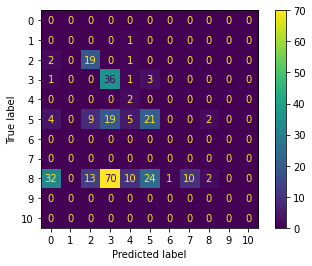

In [63]:
from sklearn import metrics
y_predicted = [int(np.where(output == np.max(output))[0]) for output in model.predict(X_test)]
cm = metrics.confusion_matrix(y_test, y_predicted, labels=[0, 1, 2, 3, 4, 5 ,6 ,7, 8, 9 ,10])
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

In [64]:
metrics.accuracy_score(y_predicted, y_test)

0.27586206896551724